<a id="installation"></a>
# Installation

In [50]:
!pip install -r scripts/requirements.txt


# Modules
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from lets_plot import *
from palmerpenguins import load_penguins
from urllib import request
from io import BytesIO
from sklearn.cluster import KMeans

# Fonctions
from scripts import import_eec


## Import des données

### Données de l'EEC de 2018 à 2024

#### Données brutes

Je n'ai pas trouvé les données dans la base Melodi et l'Insee mais directement en ligne sur le site. J'ai essayé d'utiliser la fonction `pd.read_csv()` pour les télécharger directement depuis l'URL, mais les données sont souvent compressées au format .zip avec un autre fichier de documentation. J'ai rédigé une fonction `pd.read_csv_from_zip()` qui importe le plus gros fichier .csv contenu dans le dossier zippé au bout de l'URL. J'ai aussi ajouté fait une copie des données sur le cloud de mon compte SSPCloud et mis un lien "backup" qu'on peut indiquer à la fonction si le lien direct ne fonctionne pas (j'ai vu que c'était tout le temps fait comme ça dans le cours).

In [3]:
# Liens vers les fichiers CSV accessibles directement depuis le site de l'Insee.
url_2024 = "https://www.insee.fr/fr/statistiques/fichier/8632441/FD_csv_EEC_2024.zip"
url_2023 = "https://www.insee.fr/fr/statistiques/fichier/8241122/FD_csv_EEC23.zip"
url_2022 = "https://www.insee.fr/fr/statistiques/fichier/7657353/FD_csv_EEC22.zip"
url_2021 = "https://www.insee.fr/fr/statistiques/fichier/6654604/FD_csv_EEC21.zip"
url_2020 = "https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip"
url_2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip"
url_2018 = "https://www.insee.fr/fr/statistiques/fichier/4191029/fd_eec18_csv.zip"

# J'ai aussi enregistré les fichiers .csv non compressés dans un dossier de mon compte SSPCloud,
# normalement on devrait pouvoir y accéder sans problème à ces adresses s'il y a un problème avec les autres:
url_2024_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2024.csv"
url_2023_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC23.csv"
url_2022_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2022.csv"
url_2021_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2021.csv"
url_2020_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC20.csv"
url_2019_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2019.csv"
url_2018_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC18.csv"

# Si besoin, les dictionnaires de variables des différentes enquêtes sont à ces adresses (les variables ne sont pas les mêmes d'une année sur l'autre…) :
# url_doc_2018 = "https://www.insee.fr/fr/statistiques/fichier/4191029/EEC2018_dictionnaire_2020.pdf"
# url_doc_2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/EEC2019_dictionnaire_2020.pdf"
# url_doc_2020 = "https://www.insee.fr/fr/statistiques/fichier/5393560/EEC2020_Dictionnaire_Fichier_Detail.pdf"
# url_doc_2021 = "https://www.insee.fr/fr/statistiques/fichier/6654604/EEC%202021%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail.pdf"
# url_doc_2022 = "https://www.insee.fr/fr/statistiques/fichier/7657353/EEC%202022%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail.pdf"
# url_doc_2023 = "https://www.insee.fr/fr/statistiques/fichier/8241122/EEC%202023%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail_2024_07_17.pdf"
# url_doc_2024 = "https://www.insee.fr/fr/statistiques/fichier/8632441/EEC%202024%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail_2024.pdf"



In [4]:
# Import depuis le site de l'Insee :
eec24 = import_eec.read_csv_from_zip(url_2024, backup_url = url_2024_backup, sep = ";")
eec23 = import_eec.read_csv_from_zip(url_2023, backup_url = url_2023_backup, sep = ";")
eec22 = import_eec.read_csv_from_zip(url_2022, backup_url = url_2022_backup, sep = ";")
eec21 = import_eec.read_csv_from_zip(url_2021, backup_url = url_2021_backup, sep = ";")
eec20 = import_eec.read_csv_from_zip(url_2020, backup_url = url_2020_backup, sep = ";")
eec19 = import_eec.read_csv_from_zip(url_2019, backup_url = url_2019_backup, sep = ";")
eec18 = import_eec.read_csv_from_zip(url_2018, backup_url = url_2018_backup, sep = ";")

Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/8632441/FD_csv_EEC_2024.zip


Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/8241122/FD_csv_EEC23.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_csv_EEC23.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/7657353/FD_csv_EEC22.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_EEC_2022.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/6654604/FD_csv_EEC21.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_EEC_2021.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_csv_EEC20.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_EEC_2019.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/41

In [5]:
"CSER" in eec20

True

In [6]:
# Variables qu'on voudrait garder (dictionnaire des codes 2018)
# - ACTEU : activité au sens du BIT (1: actifs occupés 2: chômeurs 3: inactifs)
# - AGE5 : je crois que c'est le plus détaillé au niveau de l'âge : il y a 5 classes d'âge - devient AGE6 en 2021
# - ANCENTR4 : ancienneté dans l'entreprise ou dans la fonction publique, 4 postes
# - ANNEE : année de référence de l'enquête
# - CATAU2010R : catégorie de la commune (pas sûr de comprendre les modalités)
# - CHPUB : nature de l'employeur principal
# - CSA : catégorie socioprofessionnelle pour les inactifs (2 chiffres)
# - CSE : catégorie socioprofessionnelle pour les actifs (2 chiffres)
# - CSP : catégorie socioprofessionnelle pour les actifs occupés (2 chiffres)
# - DIP11 : diplôme le plus élevé obtenu
# - DUHAB : type de temps de travail
# - EMPNBH : nombre d'heures effectuées dans l'emploi principal pendant la semaine de référence
# - EXTRIAN : pondération
# - FONCTC : fonction de la profession
# - HHC6 : nombre d'heures travaillées en moyenne dans l'emploi principal
# - JOURTR : nombre de jours travaillés en général par semaine
# - NAFANT : nature de l'activité de l'emploi antérieur (pour chômeurs et inactifs)
# - NAFG021UN : nature de l'activité de l'emploi principale (NAF2 à 21 postes)
# - NONDIC : raison de la non disponibilité pour travailler sous deux semaines
# - PASTRA : n'a pas travaillé la semaine de référence mais a un emploi rémunéré
# - PUB3FP : statut public ou privé de l'employeur principal
# - QPRC : position professionnelle dans l'emploi principal
# - RABS : raison de l'absence au travail la semaine de référence, pour les personnes qui ont un emploi rémunéré (2 : congé maladie ou accident du travail)
# - RAISNREC : raison principale de la non recherche d'emploi durant les quatre semaines s'achevant par la semaine de référence (4 : problèmes de santé)
# - RAISNSOU : raison pour laquelle l'individu ne souhaite pas travaille actuellement (3 : a des problèmes de santé)
# - RAISON : raison de la non-disponibilité pour travailler davantage (pour ceux qui souhaitent faire plus d'heures de travail) (4 : pour raisons de santé)
# - SEXE
# - SOUA : souhait d'avoir un emploi en remplacement de l'emploi actuel ou à venir
# - STAT2 : salarié (2) ou non salarié (1)
# - TPPRED : temps de travail dans l'emploi principal, redressé et imputé de la non-réponse partielle
# - TRAREF : exercice d'au moins une heure de travail durant la semaine de référence
# - TRIM : trimestre de référence de l'enquête (1 à 4)

vars = ['ACTEU', 
        'AGE5', 
        'ANCENTR4', 
        'ANNEE', 
        'CATAU2010R', 
        'CHPUB', 
        'CSA', 
        'CSE', 
        'CSP', 
        'DIP11', 
        'DUHAB', 
        'EMPNBH', 
        'EXTRIAN', 
        'FONCTC', 
        'HHC6', 
        'JOURTR', 
        'NAFANT', 
        'NAFG021UN',
        'NONDIC', 
        'PASTRA', 
        'PUB3FP', 
        'QPRC', 
        'RABS', 
        'RAISNREC', 
        'RAISNSOU', 
        'RAISON',
        'SEXE',
        'SOUA',
        'STAT2',
        'TPPRED',
        'TRAREF',
        'TRIM']

# Ça marche pour 2018, 2019 et 2020. Ensuite beaucoup de variables changent de nom (ou plus)

# Assemblage des tables des différentes années

Les variables présentes dans les différentes tables ne sont pas les mêmes d'année en année. Par exemple, la variable d'âge est en 5 modalités et s'appelle `AGE5` en 2018 et 2019 puis elle passe à 6 modalités avec un découpage différent à partir de 2020 et s'appelle alors `AGE6`. Dans un premier temps, on peut ne conserver que les variables qui sont présentes dans toutes les tables, en espérant que les modalités restent les mêmes la plupart du temps. Si on veut en utiliser d'autres, il faudra ajouter des recodages préalables.

In [7]:
# On crée une liste de tous tes DataFrames
dfs = [eec18, eec19, eec20, eec21, eec22, eec23, eec24]

# On calcule l'intersection des colonnes
vars_communes = set(dfs[0].columns)
for df in dfs[1:]:
    vars_communes = vars_communes.intersection(df.columns)

# On convertit en liste triée pour lecture
vars_communes = sorted(vars_communes)
print(f"{len(vars_communes)} variables communes :")
print(vars_communes)

33 variables communes :
['AAC', 'ACTEU', 'ANCCHOM', 'ANNEE', 'CHPUB', 'DISPPLC', 'ENFRED', 'EXTRIAN', 'HALOR', 'METRODOM', 'NAFANTG004N', 'NAFG004UN', 'NAFG010UN', 'NAFG017UN', 'NAFG021UN', 'NAFG038UN', 'NAFG088UN', 'OFFICC', 'PASTRA', 'PASTRB', 'PUB3FP', 'RABS', 'RAISTP', 'SEXE', 'SOUSEMPL', 'STATUT', 'STC', 'STPLC', 'TEMP', 'TPPRED', 'TRAREF', 'TRIM', 'TXTPPRED']


Il y a donc 33 variables qui sont présentes avec le même nom dans toutes les bases de 2018 à 2024. Pour ne pas s'encombrer avec des variables qu'on utilise pas, on peut faire une liste des variables qu'on veut utiliser parmi celles-ci, qu'on peut allonger selon les besoins.

In [8]:
# Liste des variables qu'on veut utiliser
core_vars = ['ACTEU', 'RABS', 'SEXE', 'RAISTP', 'TRIM', 'ANNEE', 'EXTRIAN']
# Concaténation des différents fichiers dans une seule tablea "eec_all"
eec_all = pd.concat(
    [eec18[core_vars], eec19[core_vars], eec20[core_vars], eec21[core_vars], eec22[core_vars], eec23[core_vars]],
    ignore_index = True)


In [9]:
# En fait on ne garde que les actifs en emploi (`ACTEU` == 1)
eec_actifs = eec_all[eec_all['ACTEU'] == 1]
eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)

/tmp/ipykernel_215370/116353697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)


In [10]:
LetsPlot.setup_html()

In [11]:
ggplot(eec_all, aes(x = 'SEXE')) + geom_bar()

## Le lien entre arrêts de travail et Covid-19

[Texte à retravailler - Brouillon]
Comment pallier l'absence de données sur les contaminations au Covid-19 en 2020 ? Pour déterminer les secteurs d'activité qui ont été les plus touchés sans disposer de données ouvertes permettant de croiser exposition au Covid-19 et secteur d'activité, nous proposons d'utiliser les absences pour congé maladie en 2020 comme *proxy* de l'exposition au virus lors de cette année. Nous faisons l'hypothèse que, dans le contexte pandémique de l'année 2020, les absence au travail pour maladie sont fortement corrélées à la circulation du Covid-19. Pour appuyer cette hypothèse, nous étudions dans cette section la corrélation entre l'intensité pandémique mesurée à partir du nombre d'hospitalisations pour Covid-19 et les arrêts de travail pour maladie.

### Récupération des données via l'API de Santé publique France

Tout d'abord, on peut récupérer les données concernant le nombre d'hospitalisations liées au Covid-19 via l'API Huwise de Santé publique France, sur le portail open data Odissé :  
https://odisse.santepubliquefrance.fr/explore/dataset/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/api/?sort=date

Le nombre de résultats étant fortement limité, nous avons choisi d'exporter l'ensemble de la base "Covid-19 - Sythèse des indicateurs de suivi de la pandémie", via les commandes indiquées dans la documentation ci-contre : 
https://help.opendatasoft.com/apis/ods-explore-v2/

In [12]:
import requests 

url = "https://odisse.santepubliquefrance.fr/api/explore/v2.1/catalog/datasets/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/exports/json"

response = requests.get(url)

print(response.json) # code 200 => succès

data = response.json()
df=pd.DataFrame(data)
df.head()



<bound method Response.json of <Response [200]>>


,date,lib_dep,dep,tx_pos,tx_incid,to,r,hosp,rea,rad,...,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1,lib_reg,reg
0,2020-03-21,Eure,27,NaN,NaN,0.091667,NaN,7,3,0,...,3.0,2.0,0.0,0.0,9.0,NaN,NaN,NaN,Normandie,28
1,2020-03-23,Eure,27,NaN,NaN,0.137500,NaN,15,4,0,...,3.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN,Normandie,28
2,2020-03-25,Eure,27,NaN,NaN,0.233333,NaN,22,6,0,...,6.0,1.0,0.0,0.0,18.0,NaN,NaN,NaN,Normandie,28
3,2020-03-26,Eure,27,NaN,NaN,0.312500,NaN,35,9,0,...,12.0,2.0,0.0,1.0,22.0,NaN,NaN,NaN,Normandie,28
4,2020-03-28,Eure,27,NaN,NaN,0.462500,NaN,37,10,1,...,1.0,0.0,1.0,0.0,25.0,NaN,NaN,NaN,Normandie,28


### Représentation graphique du nombre d'hospitalisations et d'absence au travail en 2020

1. On ne garde que les données pour 2020 et on s'assure de pouvoir grouper les observations par date sans données manquantes pour pouvoir sommer le nombre d'hospitalisations dans chaque département.

In [13]:
df_2020 = df[df['date'].str.contains('2020')].copy()

# On vérifie qu’il existe le même nombre de départements observés pour chaque date pour pouvoir sommer le nombre d'hospitalisations
count_by_date = df_2020.groupby('date')['dep'].nunique() # nb de départements uniques par date
print(count_by_date.unique()) # le nombre précédent est-il toujours = à 101 = nb de départements ? oui
print(df_2020['hosp'].isna().sum()) # on vérifie qu'il y avait pas de non réponses malgré la présence du département

# Conclusion: on peut group_by date sans problème / biais dû à des manques d'informations sur certains départements

df_daily = df_2020.groupby('date', as_index=False)['hosp'].sum()


[101]
0


2. On représente graphiquement le nombre d'hospitalisation en fonction du temps, avec des étiquettes mensuelles et non quotidiennes

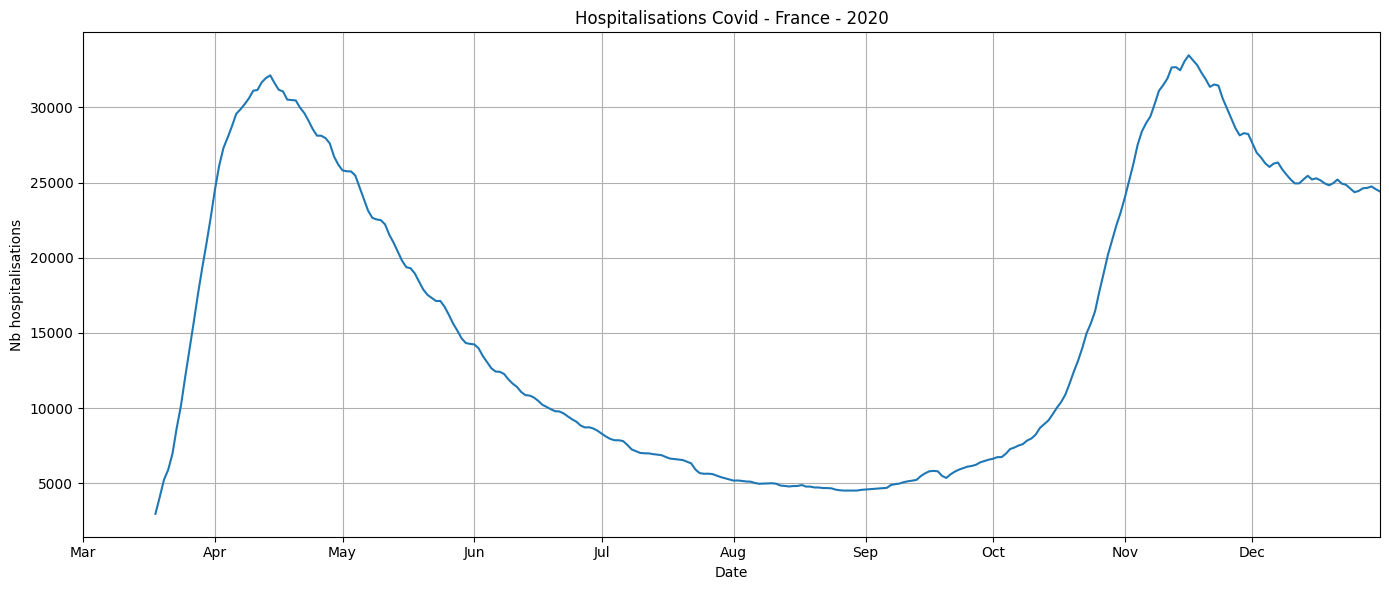

In [14]:
df_daily['date'] = pd.to_datetime(df_daily['date'])   

plt.figure(figsize=(14,6))
plt.plot(df_daily['date'], df_daily['hosp'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-31'))   

plt.title("Hospitalisations Covid - France - 2020")
plt.xlabel("Date")
plt.ylabel("Nb hospitalisations")
plt.grid(True)
plt.tight_layout()
plt.show()


3. On représente le nombre d'absence au travail pour congé maladie en 2020

Problème: les données en open data ne sont disponibles qu'avec des divisions trimestrielles et non pas hebdomadaires

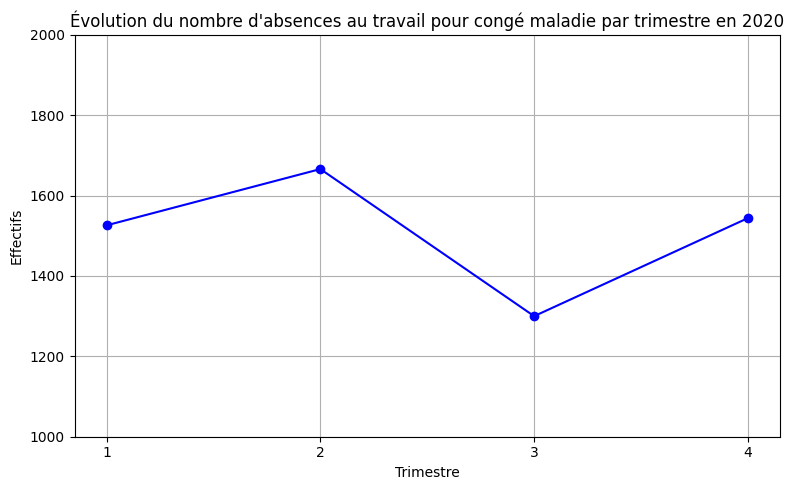

In [15]:
# On ne compte que les absences au travail que pour des raisons de congé maladie
df_rabs2 = eec20[eec20['RABS'] == 2.0].copy()

# On les groupe par trimestre et on compte le nombre d'observations
df_trim_count = df_rabs2.groupby('TRIM', as_index=False).size().rename(columns={'size': 'Effectifs'})

# Représentation graphique:
plt.figure(figsize=(8,5))
plt.plot(df_trim_count['TRIM'], df_trim_count['Effectifs'], marker='o', linestyle='-', color='blue')
plt.title("Évolution du nombre d'absences au travail pour congé maladie par trimestre en 2020")
plt.xlabel("Trimestre")
plt.ylabel("Effectifs")
plt.ylim(1000, 2000) # revoir étiquettes car trompeuses ?
plt.xticks(df_trim_count['TRIM'])  # pour que chaque trimestre ait son label
plt.grid(True)
plt.tight_layout()
plt.show()

4. Représentons les données d'hospitalisation par trimestre pour mieux comparer

In [16]:
df_daily['year'] = df_daily['date'].dt.year
df_daily['month'] = df_daily['date'].dt.month
df_daily_2020 = df_daily[df_daily['year'] == 2020].copy()

# 4) Calcul des trimestres
T1 = df_daily_2020[df_daily_2020['month'] == 3]['hosp'].sum() * 3 # T1 est corrigé (multiplié par 3) parce qu’il ne contient que mars
T2 = df_daily_2020[df_daily_2020['month'].isin([4,5,6])]['hosp'].sum()
T3 = df_daily_2020[df_daily_2020['month'].isin([7,8,9])]['hosp'].sum()
T4 = df_daily_2020[df_daily_2020['month'].isin([10,11,12])]['hosp'].sum()

df_trim = pd.DataFrame({
    "TRIM": ["T1","T2","T3","T4"],
    "hosp": [T1, T2, T3, T4]
})

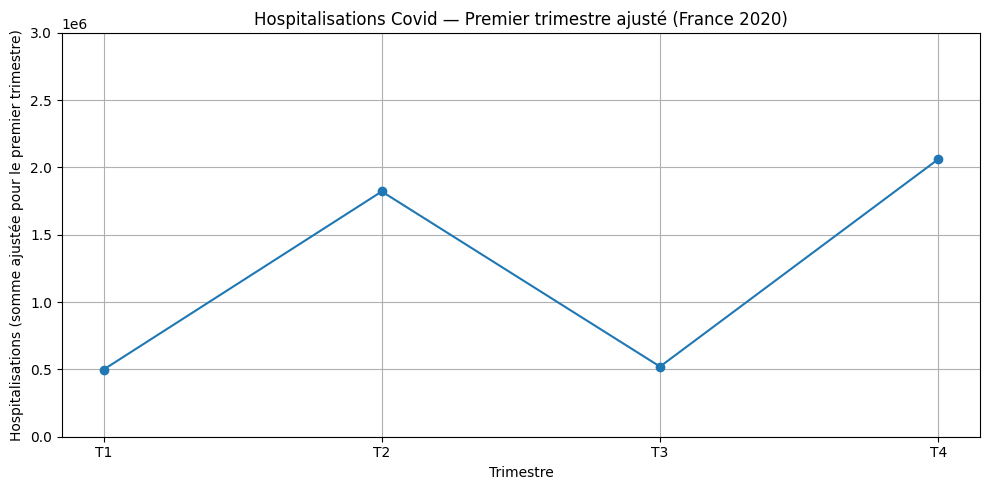

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df_trim["TRIM"], df_trim["hosp"], marker="o")

plt.title("Hospitalisations Covid — Premier trimestre ajusté (France 2020)")
plt.xlabel("Trimestre")
plt.ylabel("Hospitalisations (somme ajustée pour le premier trimestre)")
plt.grid(True)
plt.ylim(0, 3000000)
plt.tight_layout()
plt.show()

=> jsp si c'est vraiment concluant d'agréger par trimestre en perdant plein d'information, il vaut peut être mieux récupérer d'autres données sur des arrêts de travail par jour / semaine 

+ attention ce sont pas les mêmes échelles: peut être trompeur
Mais globalement ce n'est pas le coeur du devoir, juste en intro et on voit bien le lien entre les deux variables: mtn but: différencier les secteurs d'activité


=> faire un score de corrélation ? 

In [18]:
df_trim.head()

,TRIM,hosp
0,T1,498366
1,T2,1821618
2,T3,520823
3,T4,2061422


In [19]:

df_trim_count.head()

,TRIM,Effectifs
0,1,1526
1,2,1666
2,3,1300
3,4,1544


In [20]:
df_trim_count['TRIM'] = df_trim_count['TRIM'].map({1: 'T1', 2: 'T2', 3: 'T3', 4: 'T4'})

df_corr = pd.merge(df_trim, df_trim_count, on='TRIM', how='inner')

# Calcul de la corrélation
correlation = df_corr['hosp'].corr(df_corr['Effectifs'])

print("Corrélation trimestrielle hospitalisations / absences au travail (congés maladies) :", correlation)



Corrélation trimestrielle hospitalisations / absences au travail (congés maladies) : 0.6763742448418546


==> corrélation trimestrielle d'environ 0.7 pour un proxy: largement acceptable. Après on peut évoquer le fait que les données sont limitées, la corrélation aurait peut baisser avec des données moins "lissées" et avec plus de bruit (données plus détaillées) qui peuvent en plus contenir un décalage

## Catégorisation des secteurs exposés et moins exposés

### Statistiques descriptives

Quelle est la proportion d'absence au travail pour congé maladie par secteur d'activité ? Y at-il des différences notables ?

In [21]:
# 1) Effectifs totaux par secteur
totaux = eec20.groupby('CSE').size().rename('effectif_total')

# 2) Effectifs RABS = 2 par secteur
rabs2 = eec20[eec20['RABS'] == 2].groupby('CSE').size().rename('effectif_rabs2')

# 3) Fusion des deux tableaux
df_prop = pd.concat([totaux, rabs2], axis=1)

# 4) Calcul de la proportion
df_prop['proportion_rabs2'] = df_prop['effectif_rabs2'] / df_prop['effectif_total']

print(df_prop)

      effectif_total  effectif_rabs2  proportion_rabs2
CSE                                                   
0.0              845            20.0          0.023669
11.0            1123            18.0          0.016028
12.0             321             5.0          0.015576
13.0             970            12.0          0.012371
21.0            5287            78.0          0.014753
22.0            4606            47.0          0.010204
23.0             933            12.0          0.012862
31.0            3169            28.0          0.008836
33.0            2943            48.0          0.016310
34.0            4799            95.0          0.019796
35.0            1788            18.0          0.010067
37.0            8475           146.0          0.017227
38.0            8451           125.0          0.014791
42.0            6256           140.0          0.022379
43.0            9191           386.0          0.041998
44.0              63             NaN               NaN
45.0      

In [22]:
# Dictionnaire de recodage CSE → label texte
cse_map = {
    0:  "Non renseigné",
    10: "Agriculteurs",
    11: "Agriculteurs petite exploitation",
    12: "Agriculteurs moyenne exploitation",
    13: "Agriculteurs grande exploitation",
    21: "Artisans",
    22: "Commerçants et assimilés",
    23: "Chefs d'entreprise (10 salariés ou plus)",
    31: "Professions libérales",
    33: "Cadres de la fonction publique",
    34: "Professeurs, professions scientifiques",
    35: "Information, arts, spectacles",
    37: "Cadres administratifs et commerciaux",
    38: "Ingénieurs et cadres techniques",
    42: "Instituteurs et assimilés",
    43: "Professions santé & travail social",
    44: "Clergé, religieux",
    45: "Intermédiaires admin. fonction publique",
    46: "Intermédiaires admin. & commerciaux",
    47: "Techniciens",
    48: "Contremaîtres, agents de maîtrise",
    52: "Employés civils & agents de service FP",
    53: "Policiers & militaires",
    54: "Employés administratifs d'entreprise",
    55: "Employés de commerce",
    56: "Services directs aux particuliers",
    62: "Ouvriers qualifiés type industriel",
    63: "Ouvriers qualifiés type artisanal",
    64: "Chauffeurs",
    65: "Ouvriers manutention / magasinage / transport",
    67: "Ouvriers non qualifiés type industriel",
    68: "Ouvriers non qualifiés type artisanal",
    69: "Ouvriers agricoles",
    81: "Chômeurs n’ayant jamais travaillé"
}


In [23]:
# Conversion float → int pour CSE
eec20['CSE_int'] = eec20['CSE'].astype('Int64')  # gère aussi les valeurs manquantes

# Recodage en labels texte
eec20['CSE_label'] = eec20['CSE_int'].map(cse_map)

# Effectifs totaux par secteur
totaux = eec20.groupby('CSE_label').size().rename('effectif_total')

# Effectifs RABS = 2
rabs2 = eec20[eec20['RABS'] == 2].groupby('CSE_label').size().rename('effectif_rabs2')

# Fusion
df_prop = pd.concat([totaux, rabs2], axis=1).fillna(0)

# Proportion
df_prop['proportion_rabs2'] = df_prop['effectif_rabs2'] / df_prop['effectif_total']

In [24]:
df_prop_sorted = df_prop.sort_values('proportion_rabs2', ascending=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print(df_prop_sorted)
df_prop_sorted
# attention les « arrêts maladie » incluent uniquement les personnes en emploi, pas les inactifs
# Donc les proportions sont mécaniquement plus faibles que dans les données administratives

                                               effectif_total  effectif_rabs2  proportion_rabs2
CSE_label                                                                                      
Employés civils & agents de service FP                  14169           814.0          0.057449
Chauffeurs                                               3911           197.0          0.050371
Ouvriers qualifiés type industriel                       5896           271.0          0.045963
Ouvriers manutention / magasinage / transport            2714           116.0          0.042741
Professions santé & travail social                       9191           386.0          0.041998
Ouvriers non qualifiés type artisanal                    4525           178.0          0.039337
Contremaîtres, agents de maîtrise                        3364           132.0          0.039239
Policiers & militaires                                   2809           110.0          0.039160
Ouvriers non qualifiés type industriel  

,effectif_total,effectif_rabs2,proportion_rabs2
CSE_label,,,
Employés civils & agents de service FP,14169,814.0,0.057449
Chauffeurs,3911,197.0,0.050371
Ouvriers qualifiés type industriel,5896,271.0,0.045963
Ouvriers manutention / magasinage / transport,2714,116.0,0.042741
Professions santé & travail social,9191,386.0,0.041998
Ouvriers non qualifiés type artisanal,4525,178.0,0.039337
"Contremaîtres, agents de maîtrise",3364,132.0,0.039239
Policiers & militaires,2809,110.0,0.039160
Ouvriers non qualifiés type industriel,5452,211.0,0.038701


In [25]:
# méthode la plus simple de clasffication en 3 groupes : quantiles de 

df_prop_sorted["exposition"] = pd.qcut(
    df_prop_sorted["proportion_rabs2"], 
    q=3,
    labels=["Faible", "Moyenne", "Forte"]
)

df_group_stats = df_prop_sorted.groupby("exposition")["proportion_rabs2"].agg(
    ['count', 'mean', 'min', 'max']
)

df_group_stats

df_reset = df_prop_sorted.reset_index()  # index → CSE_label
# Ajouter un compteur pour chaque secteur dans son groupe
df_reset["rang"] = df_reset.groupby("exposition").cumcount()
df_large = df_reset.pivot(index="rang", columns="exposition", values="CSE_label")
df_large

/tmp/ipykernel_215370/182030512.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group_stats = df_prop_sorted.groupby("exposition")["proportion_rabs2"].agg(
/tmp/ipykernel_215370/182030512.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_reset["rang"] = df_reset.groupby("exposition").cumcount()


exposition,Faible,Moyenne,Forte
rang,,,
0,Agriculteurs petite exploitation,Employés de commerce,Employés civils & agents de service FP
1,Agriculteurs moyenne exploitation,Services directs aux particuliers,Chauffeurs
2,Ingénieurs et cadres techniques,Intermédiaires admin. fonction publique,Ouvriers qualifiés type industriel
3,Artisans,Ouvriers agricoles,Ouvriers manutention / magasinage / transport
4,Chefs d'entreprise (10 salariés ou plus),Intermédiaires admin. & commerciaux,Professions santé & travail social
5,Agriculteurs grande exploitation,Non renseigné,Ouvriers non qualifiés type artisanal
6,Commerçants et assimilés,Instituteurs et assimilés,"Contremaîtres, agents de maîtrise"
7,"Information, arts, spectacles",Techniciens,Policiers & militaires
8,Professions libérales,"Professeurs, professions scientifiques",Ouvriers non qualifiés type industriel


### Contrôle par le nombre d'arrêt de travail précédant le Covid

Etant donné qu'il y a sûrement des différences structurelles dans la proportion d'actifs en arrêt maladie selon le secteur d'activité (pénibilité du travail, risques différenciés...), on peut regarder la différence entre cette exposition en 2020 et en 2019, pour ainsi calculer un meilleur proxy de l'exposition au covid


In [26]:
# Ajout du label dans eec19
eec19["CSE_label"] = eec19["CSE"].map(cse_map)

# 1. Calculer la proportion RABS=2 en 2019 par secteur

tot_19 = (
    eec19.groupby("CSE_label")
    .size()
    .rename("effectif_total_2019")
)

r2_19 = (
    eec19[eec19["RABS"] == 2]
    .groupby("CSE_label")
    .size()
    .rename("effectif_rabs2_2019")
)

# Proportion 2019
prop_19 = (r2_19 / tot_19).rename("proportion_rabs2_2019")


# 2. Fusionner la proportion 2019 avec ton tableau 2020
df_prop_sorted = (
    df_prop_sorted
    .merge(tot_19, on="CSE_label", how="left")
    .merge(r2_19, on="CSE_label", how="left")
    .merge(prop_19, on="CSE_label", how="left")
)

# 3. Calculer la différence 2020 - 2019
df_prop_sorted["proportion_rabs2_2019"] = df_prop_sorted["proportion_rabs2_2019"].fillna(0)
df_prop_sorted["diff_2020_2019"] = df_prop_sorted["proportion_rabs2"] - df_prop_sorted["proportion_rabs2_2019"]


df_prop_sorted = df_prop_sorted[[
    "effectif_total",
    "effectif_rabs2",
    "proportion_rabs2",
    "effectif_total_2019",
    "effectif_rabs2_2019",
    "proportion_rabs2_2019",
    "diff_2020_2019"    
]]


df_prop_sorted


,effectif_total,effectif_rabs2,proportion_rabs2,effectif_total_2019,effectif_rabs2_2019,proportion_rabs2_2019,diff_2020_2019
CSE_label,,,,,,,
Employés civils & agents de service FP,14169,814.0,0.057449,19120,874.0,0.045711,0.011738
Chauffeurs,3911,197.0,0.050371,5312,198.0,0.037274,0.013097
Ouvriers qualifiés type industriel,5896,271.0,0.045963,8250,331.0,0.040121,0.005842
Ouvriers manutention / magasinage / transport,2714,116.0,0.042741,3544,155.0,0.043736,-0.000995
Professions santé & travail social,9191,386.0,0.041998,11762,335.0,0.028482,0.013516
Ouvriers non qualifiés type artisanal,4525,178.0,0.039337,6366,220.0,0.034559,0.004778
"Contremaîtres, agents de maîtrise",3364,132.0,0.039239,4466,127.0,0.028437,0.010802
Policiers & militaires,2809,110.0,0.039160,3586,116.0,0.032348,0.006812
Ouvriers non qualifiés type industriel,5452,211.0,0.038701,7322,217.0,0.029637,0.009065


In [27]:
#1. Création de la variable exposition2
df_prop_sorted["exposition2"] = pd.qcut(
    df_prop_sorted["diff_2020_2019"],
    q=3,
    labels=["Faible", "Moyenne", "Forte"]
)

df_reset2 = df_prop_sorted.reset_index()
df_reset2["rang"] = df_reset2.groupby("exposition2").cumcount()

df_large2 = df_reset2.pivot(index="rang", columns="exposition2", values="CSE_label")
df_large2


/tmp/ipykernel_215370/3420931973.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_reset2["rang"] = df_reset2.groupby("exposition2").cumcount()


exposition2,Faible,Moyenne,Forte
rang,,,
0,Ouvriers manutention / magasinage / transport,Ouvriers qualifiés type industriel,Employés civils & agents de service FP
1,Ouvriers agricoles,Ouvriers non qualifiés type artisanal,Chauffeurs
2,Techniciens,Ouvriers qualifiés type artisanal,Professions santé & travail social
3,Cadres administratifs et commerciaux,Employés de commerce,"Contremaîtres, agents de maîtrise"
4,Cadres de la fonction publique,Services directs aux particuliers,Policiers & militaires
5,Artisans,Intermédiaires admin. & commerciaux,Ouvriers non qualifiés type industriel
6,Agriculteurs grande exploitation,Instituteurs et assimilés,Employés administratifs d'entreprise
7,"Information, arts, spectacles","Professeurs, professions scientifiques",Intermédiaires admin. fonction publique
8,Professions libérales,Agriculteurs moyenne exploitation,Non renseigné


Qu'est-ce qui a changé ?

In [28]:

# Recréer la variable exposition (basée sur quantiles proportion 2020)
df_prop_sorted["exposition"] = pd.qcut(
    df_prop_sorted["proportion_rabs2"],
    q=3,
    labels=["Faible", "Moyenne", "Forte"]
)

df_expos = df_prop_sorted[["exposition", "exposition2"]]

# Affichage
df_expos

,exposition,exposition2
CSE_label,,
Employés civils & agents de service FP,Forte,Forte
Chauffeurs,Forte,Forte
Ouvriers qualifiés type industriel,Forte,Moyenne
Ouvriers manutention / magasinage / transport,Forte,Faible
Professions santé & travail social,Forte,Forte
Ouvriers non qualifiés type artisanal,Forte,Moyenne
"Contremaîtres, agents de maîtrise",Forte,Forte
Policiers & militaires,Forte,Forte
Ouvriers non qualifiés type industriel,Forte,Forte


Si on compare avec les secteurs d'activité

In [29]:
eec20["NAFG038UN"].value_counts()

NAFG038UN
GZ    18203
OZ    14714
PZ    12303
QA    11062
QB    10494
FZ     9736
HZ     7400
MA     6073
NZ     5576
IZ     5105
KZ     4969
AZ     3866
SZ     3801
CA     3544
JC     2569
RZ     2349
CH     2232
00     2195
CL     2027
CM     1823
TZ     1781
LZ     1734
CG     1513
MC     1419
JA     1353
EZ     1128
CC     1089
DZ     1067
CK     1016
MB      948
CE      833
CI      810
CB      735
JB      660
CJ      610
CF      471
BZ      132
UZ      125
CD       31
Name: count, dtype: int64

In [30]:
naf_map = {
    "": "Sans objet (inactifs occupés)",
    "00": "Non renseigné",
    "AZ": "Agriculture, sylviculture et pêche",
    "BZ": "Industries extractives",
    "CA": "Alimentaire, boissons, tabac",
    "CB": "Textile, habillement, cuir, chaussure",
    "CC": "Bois, papier, imprimerie",
    "CD": "Cokéfaction et raffinage",
    "CE": "Industrie chimique",
    "CF": "Industrie pharmaceutique",
    "CG": "Caoutchouc, plastique, minéraux non métalliques",
    "CH": "Métallurgie et produits métalliques",
    "CI": "Informatique, électronique, optique",
    "CJ": "Équipements électriques",
    "CK": "Machines et équipements",
    "CL": "Matériels de transport",
    "CM": "Autres industries manufacturières; réparation & installation",
    "DZ": "Électricité, gaz, vapeur, air conditionné",
    "EZ": "Eau, déchets, dépollution",
    "FZ": "Construction",
    "GZ": "Commerce, réparation auto/moto",
    "HZ": "Transports et entreposage",
    "IZ": "Hébergement et restauration",
    "JA": "Édition, audiovisuel, diffusion",
    "JB": "Télécommunications",
    "JC": "Informatique & services d'information",
    "KZ": "Activités financières et d’assurance",
    "LZ": "Activités immobilières",
    "MA": "Juridique, comptable, gestion, architecture, ingénierie",
    "MB": "Recherche-développement scientifique",
    "MC": "Autres activités spécialisées, scientifiques & techniques",
    "NZ": "Services administratifs & soutien",
    "OZ": "Administration publique",
    "PZ": "Enseignement",
    "QA": "Activités pour la santé humaine",
    "QB": "Hébergement médico-social & action sociale",
    "RZ": "Arts, spectacles, activités récréatives",
    "SZ": "Autres activités de services",
    "TZ": "Activités des ménages employeurs & production pour usage propre",
    "UZ": "Activités extra-territoriales"
}

eec20["NAF_label"] = eec20["NAFG038UN"].map(naf_map)
eec20["NAF_label"].value_counts()

NAF_label
Commerce, réparation auto/moto                                     18203
Administration publique                                            14714
Enseignement                                                       12303
Activités pour la santé humaine                                    11062
Hébergement médico-social & action sociale                         10494
Construction                                                        9736
Transports et entreposage                                           7400
Juridique, comptable, gestion, architecture, ingénierie             6073
Services administratifs & soutien                                   5576
Hébergement et restauration                                         5105
Activités financières et d’assurance                                4969
Agriculture, sylviculture et pêche                                  3866
Autres activités de services                                        3801
Alimentaire, boissons, tabac             

In [31]:
# 1) Effectifs totaux par secteur
totaux = eec20.groupby('NAF_label').size().rename('effectif_total')

# 2) Effectifs RABS = 2 par secteur
rabs2 = eec20[eec20['RABS'] == 2].groupby('NAF_label').size().rename('effectif_rabs2')

# 3) Fusion des deux tableaux
df_prop = pd.concat([totaux, rabs2], axis=1)

# 4) Calcul de la proportion
df_prop['proportion_rabs2'] = df_prop['effectif_rabs2'] / df_prop['effectif_total']

print(df_prop)

                                                    effectif_total  effectif_rabs2  proportion_rabs2
NAF_label                                                                                           
Activités des ménages employeurs & production p...            1781              47          0.026390
Activités extra-territoriales                                  125               2          0.016000
Activités financières et d’assurance                          4969             124          0.024955
Activités immobilières                                        1734              46          0.026528
Activités pour la santé humaine                              11062             464          0.041945
Administration publique                                      14714             592          0.040234
Agriculture, sylviculture et pêche                            3866              75          0.019400
Alimentaire, boissons, tabac                                  3544             147         

In [32]:
# Ajout du label dans eec19
eec19["NAF_label"] = eec19["NAFG038UN"].map(naf_map)

# 1. Calculer la proportion RABS=2 en 2019 par secteur

tot_19 = (
    eec19.groupby("NAF_label")
    .size()
    .rename("effectif_total_2019")
)

r2_19 = (
    eec19[eec19["RABS"] == 2]
    .groupby("NAF_label")
    .size()
    .rename("effectif_rabs2_2019")
)

# Proportion 2019
prop_19 = (r2_19 / tot_19).rename("proportion_rabs2_2019")


# 2. Fusionner la proportion 2019 avec ton tableau 2020
df_prop = (
    df_prop
    .merge(tot_19, on="NAF_label", how="left")
    .merge(r2_19, on="NAF_label", how="left")
    .merge(prop_19, on="NAF_label", how="left")
)

# 3. Calculer la différence 2020 - 2019
df_prop["proportion_rabs2_2019"] = df_prop["proportion_rabs2_2019"].fillna(0)
df_prop["diff_2020_2019"] = df_prop["proportion_rabs2"] - df_prop["proportion_rabs2_2019"]


df_prop = df_prop[[
    "effectif_total",
    "effectif_rabs2",
    "proportion_rabs2",
    "effectif_total_2019",
    "effectif_rabs2_2019",
    "proportion_rabs2_2019",
    "diff_2020_2019"    
]]


In [33]:
df_prop = df_prop.sort_values('diff_2020_2019', ascending=False)
df_prop

,effectif_total,effectif_rabs2,proportion_rabs2,effectif_total_2019,effectif_rabs2_2019,proportion_rabs2_2019,diff_2020_2019
NAF_label,,,,,,,
Industrie pharmaceutique,471,21,0.044586,603,10,0.016584,0.028002
Industries extractives,132,5,0.037879,202,3,0.014851,0.023027
Équipements électriques,610,31,0.050820,752,25,0.033245,0.017575
"Eau, déchets, dépollution",1128,50,0.044326,1468,44,0.029973,0.014353
Hébergement médico-social & action sociale,10494,614,0.058510,13897,647,0.046557,0.011953
Métallurgie et produits métalliques,2232,90,0.040323,3057,91,0.029768,0.010555
Administration publique,14714,592,0.040234,18893,569,0.030117,0.010117
Activités pour la santé humaine,11062,464,0.041945,14586,467,0.032017,0.009928
Machines et équipements,1016,29,0.028543,1426,27,0.018934,0.009609


In [34]:
#1. Création de la variable exposition3
df_prop["exposition3"] = pd.qcut(
    df_prop["diff_2020_2019"],
    q=3,
    labels=["Faible", "Moyenne", "Forte"]
)

df_reset2 = df_prop.reset_index()
df_reset2["rang"] = df_reset2.groupby("exposition3").cumcount()

df_large2 = df_reset2.pivot(index="rang", columns="exposition3", values="NAF_label")
df_large2

/tmp/ipykernel_215370/2461167868.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_reset2["rang"] = df_reset2.groupby("exposition3").cumcount()


exposition3,Faible,Moyenne,Forte
rang,,,
0,Activités des ménages employeurs & production ...,"Autres activités spécialisées, scientifiques &...",Industrie pharmaceutique
1,"Juridique, comptable, gestion, architecture, i...",Autres industries manufacturières; réparation ...,Industries extractives
2,"Agriculture, sylviculture et pêche",Autres activités de services,Équipements électriques
3,Construction,"Commerce, réparation auto/moto","Eau, déchets, dépollution"
4,"Bois, papier, imprimerie","Caoutchouc, plastique, minéraux non métalliques",Hébergement médico-social & action sociale
5,Télécommunications,Transports et entreposage,Métallurgie et produits métalliques
6,Informatique & services d'information,"Textile, habillement, cuir, chaussure",Administration publique
7,Matériels de transport,Recherche-développement scientifique,Activités pour la santé humaine
8,"Édition, audiovisuel, diffusion",Activités immobilières,Machines et équipements


### Création d'un score d'exposition combinant nos deux indicateurs d'exposition 



In [35]:
df_prop_sorted["exposition2"]
df_prop["exposition3"]

# But: créer pour chaque individu un score d'exposition
# 1 - on mets les variables exposition2 et exposition3 dans la base eec20
# 2 - on crée une 3e variable score à partir des valeurs jointes de ces deux variables


NAF_label
Industrie pharmaceutique                                             Forte
Industries extractives                                               Forte
Équipements électriques                                              Forte
Eau, déchets, dépollution                                            Forte
Hébergement médico-social & action sociale                           Forte
Métallurgie et produits métalliques                                  Forte
Administration publique                                              Forte
Activités pour la santé humaine                                      Forte
Machines et équipements                                              Forte
Arts, spectacles, activités récréatives                              Forte
Alimentaire, boissons, tabac                                         Forte
Enseignement                                                         Forte
Services administratifs & soutien                                    Forte
Autres activité

In [36]:
# Table exposition2 (CSE)
df_expo2 = df_prop_sorted[['exposition2']].reset_index().rename(columns={'index': 'CSE_label'})

# Table exposition3 (NAF)
df_expo3 = df_prop[['exposition3']].reset_index().rename(columns={'index': 'NAF_label'})

eec20_actifs = eec20[eec20['ACTEU'] == 1]

pd.crosstab(eec20_actifs["CSE_label"], eec20["NAF_label"])

NAF_label,Activités des ménages employeurs & production pour usage propre,Activités extra-territoriales,Activités financières et d’assurance,Activités immobilières,Activités pour la santé humaine,Administration publique,"Agriculture, sylviculture et pêche","Alimentaire, boissons, tabac","Arts, spectacles, activités récréatives",Autres activités de services,"Autres activités spécialisées, scientifiques & techniques",Autres industries manufacturières; réparation & installation,"Bois, papier, imprimerie","Caoutchouc, plastique, minéraux non métalliques",Cokéfaction et raffinage,"Commerce, réparation auto/moto",Construction,"Eau, déchets, dépollution",Enseignement,Hébergement et restauration,Hébergement médico-social & action sociale,Industrie chimique,Industrie pharmaceutique,Industries extractives,Informatique & services d'information,"Informatique, électronique, optique","Juridique, comptable, gestion, architecture, ingénierie",Machines et équipements,Matériels de transport,Métallurgie et produits métalliques,Non renseigné,Recherche-développement scientifique,Services administratifs & soutien,"Textile, habillement, cuir, chaussure",Transports et entreposage,Télécommunications,"Édition, audiovisuel, diffusion","Électricité, gaz, vapeur, air conditionné",Équipements électriques
CSE_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agriculteurs grande exploitation,0,0,0,0,0,0,934,1,4,0,0,0,0,0,0,9,5,0,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,7,0
Agriculteurs moyenne exploitation,0,0,0,0,0,0,276,0,5,0,0,0,3,0,0,14,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,14,0,2,0,0,0,0
Agriculteurs petite exploitation,0,0,0,0,0,0,1069,3,4,0,1,0,0,0,0,5,4,0,3,2,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,16,0
Artisans,1,0,3,0,18,0,26,170,25,779,23,246,66,39,0,536,2149,19,15,58,0,4,0,0,8,5,17,22,6,53,30,0,304,105,390,0,12,2,11
Cadres administratifs et commerciaux,0,18,1852,248,32,264,28,82,77,226,236,37,40,53,0,1413,175,46,190,208,111,65,45,4,232,43,923,60,85,56,78,53,364,33,305,120,122,102,42
Cadres de la fonction publique,0,37,2,9,175,2022,6,4,64,42,0,0,0,0,0,0,7,22,200,3,78,0,0,0,4,0,6,0,3,0,6,79,4,0,84,32,4,10,0
Chauffeurs,0,0,6,0,41,97,19,75,6,19,91,10,9,20,0,390,159,159,9,73,24,1,0,11,6,0,4,0,0,16,44,0,87,3,2203,0,16,0,0
Chefs d'entreprise (10 salariés ou plus),1,0,42,15,13,26,6,30,15,14,14,9,13,15,0,156,149,4,20,49,13,4,0,0,41,4,39,2,4,13,15,5,81,13,51,0,13,1,8
"Clergé, religieux",0,0,0,0,2,0,0,0,0,47,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,7,0,2,0,0,0,0,0,0


In [37]:
# Ajout exposition2 via CSE_label
eec20_actifs = eec20_actifs.merge(df_expo2, on='CSE_label', how='left')

# Ajout exposition3 via NAF_label
eec20_actifs = eec20_actifs.merge(df_expo3, on='NAF_label', how='left')

In [38]:
mapping = {
    "Faible": 0,
    "Moyenne": 1,
    "Forte": 2
}

eec20_actifs['exposition2_rec'] = eec20_actifs['exposition2'].map(mapping)
eec20_actifs['exposition3_rec'] = eec20_actifs['exposition3'].map(mapping)


In [39]:
eec20_actifs["exposition2_rec"].dtype

CategoricalDtype(categories=[0, 1, 2], ordered=True, categories_dtype=int64)

In [40]:
eec20_actifs['exposition2_rec_int'] = eec20_actifs['exposition2_rec'].astype(int)
eec20_actifs['exposition3_rec_int'] = eec20_actifs['exposition3_rec'].astype(int)

eec20_actifs['score_exposition'] = (
    eec20_actifs['exposition2_rec_int'] + eec20_actifs['exposition3_rec_int']
)

In [41]:
cols_check = [
    "CSE_label", "NAF_label",
    "exposition2", "exposition3",
    "exposition2_rec", "exposition3_rec",
    "score_exposition"
]

print(eec20_actifs[cols_check].head(30))

                                 CSE_label                                          NAF_label exposition2 exposition3 exposition2_rec exposition3_rec  score_exposition
0                               Chauffeurs                                       Construction       Forte      Faible               2               0                 2
1                               Chauffeurs                                       Construction       Forte      Faible               2               0                 2
2                               Chauffeurs                                       Construction       Forte      Faible               2               0                 2
3       Professions santé & travail social  Autres industries manufacturières; réparation ...       Forte     Moyenne               2               1                 3
4       Professions santé & travail social                    Activités pour la santé humaine       Forte       Forte               2               2           

In [42]:
# Tableau

# Effectifs
effectifs = eec20_actifs['score_exposition'].value_counts().sort_index()

# Pourcentages
frequences = eec20_actifs['score_exposition'].value_counts(normalize=True).sort_index() * 100

# Combiner dans un DataFrame
df_score_dist = pd.DataFrame({
    "effectif": effectifs,
    "pourcentage": frequences
})

# Affichage
print(df_score_dist)

                  effectif  pourcentage
score_exposition                       
0                    11287     7.652411
1                    26116    17.706243
2                    40696    27.591257
3                    38546    26.133590
4                    30851    20.916499


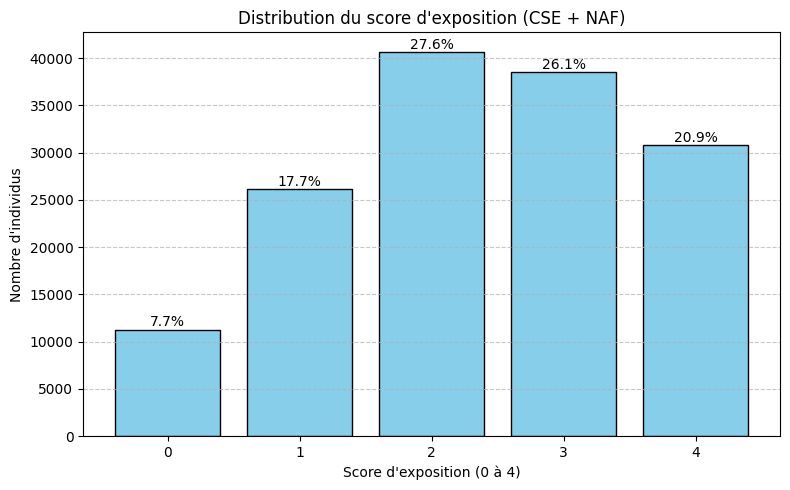

In [43]:
plt.figure(figsize=(8,5))
bars = plt.bar(df_score_dist.index, df_score_dist['effectif'], color='skyblue', edgecolor='black')

# Ajouter les pourcentages au-dessus des barres
for bar, pct in zip(bars, df_score_dist['pourcentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f"{pct:.1f}%", ha='center', va='bottom', fontsize=10)

plt.xticks(df_score_dist.index)
plt.xlabel("Score d'exposition (0 à 4)")
plt.ylabel("Nombre d'individus")
plt.title("Distribution du score d'exposition (CSE + NAF)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
# Différente répartition du genre dans la base de 2020 et dans les groupes exposés et moins exposés

# Effectifs par genre
effectifs_genre = eec20_actifs['SEXE'].value_counts()

# Pourcentages
frequences_genre = eec20_actifs['SEXE'].value_counts(normalize=True) * 100

# Combiner dans un DataFrame
df_genre = pd.DataFrame({
    'effectif': effectifs_genre,
    'pourcentage': frequences_genre
})

print(df_genre)

df_genre_score = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['SEXE'],
    margins=True,       # Ajoute une ligne et colonne 'All' pour total
    normalize=False     # Pour obtenir les effectifs
)

print(df_genre_score)

df_genre_score_pct = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['SEXE'],
    normalize='index'   # normalise par ligne → proportion par score
) * 100

print(df_genre_score_pct)


      effectif  pourcentage
SEXE                       
1        74718    50.657645
2        72778    49.342355
SEXE                  1      2     All
score_exposition                      
0                  8335   2952   11287
1                 17218   8898   26116
2                 21572  19124   40696
3                 17856  20690   38546
4                  9737  21114   30851
All               74718  72778  147496
SEXE                      1          2
score_exposition                      
0                 73.846018  26.153982
1                 65.928932  34.071068
2                 53.007667  46.992333
3                 46.323873  53.676127
4                 31.561376  68.438624


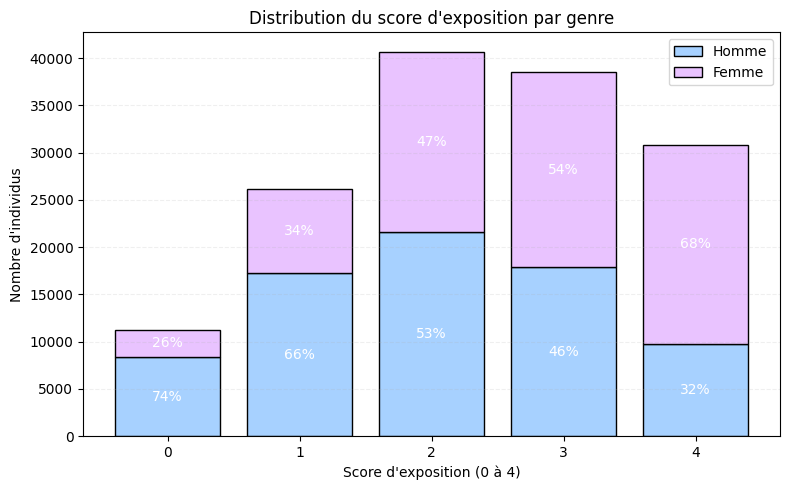

In [45]:
# 1️ Crosstab score_exposition vs sexe
df_genre_score = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['SEXE']  # 1 = Homme, 2 = Femme
)

# Renommer les colonnes pour la légende
df_genre_score.rename(columns={1: 'Homme', 2: 'Femme'}, inplace=True)

# 2️ Graphique à barres empilées
plt.figure(figsize=(8,5))

bars_homme = plt.bar(df_genre_score.index, df_genre_score['Homme'], color='#A7D1FF', edgecolor='black', label='Homme')
bars_femme = plt.bar(df_genre_score.index, df_genre_score['Femme'], bottom=df_genre_score['Homme'],
                     color='#E9C3FF', edgecolor='black', label='Femme')

# Ajouter les pourcentages au centre de chaque segment
for i, row in df_genre_score.iterrows():
    total = row.sum()
    plt.text(i, row['Homme']/2, f"{row['Homme']/total*100:.0f}%", ha='center', va='center', color='white', fontsize=10)
    plt.text(i, row['Homme'] + row['Femme']/2, f"{row['Femme']/total*100:.0f}%", ha='center', va='center', color='white', fontsize=10)

plt.xticks(df_genre_score.index)
plt.xlabel("Score d'exposition (0 à 4)")
plt.ylabel("Nombre d'individus")
plt.title("Distribution du score d'exposition par genre")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


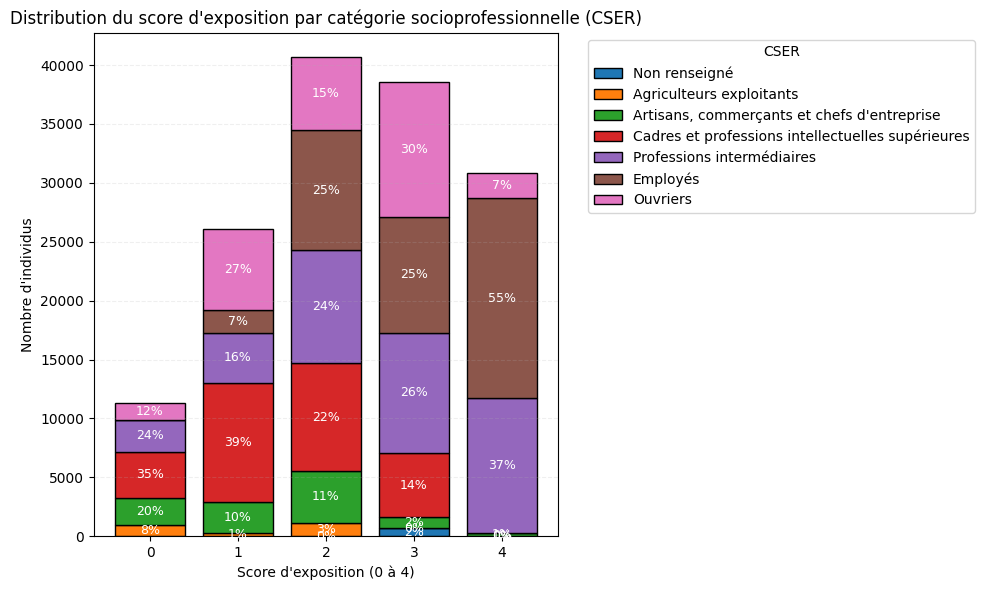

In [46]:
# Dictionnaire des libellés CSER (codes conservés)
cser_labels = {
    0: "Non renseigné",
    1: "Agriculteurs exploitants",
    2: "Artisans, commerçants et chefs d'entreprise",
    3: "Cadres et professions intellectuelles supérieures",
    4: "Professions intermédiaires",
    5: "Employés",
    6: "Ouvriers",
 }

# 1️⃣ Crosstab score_exposition vs CSER
df_cser_score = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['CSER']
)

# Garder uniquement les modalités voulues et les renommer
df_cser_score = df_cser_score[cser_labels.keys()]
df_cser_score.rename(columns=cser_labels, inplace=True)

# 2️⃣ Graphique à barres empilées
plt.figure(figsize=(10,6))

bottom = np.zeros(len(df_cser_score))

for cser in df_cser_score.columns:
    plt.bar(
        df_cser_score.index,
        df_cser_score[cser],
        bottom=bottom,
        label=cser,
        edgecolor='black'
    )
    bottom += df_cser_score[cser].values

# Ajouter les pourcentages au centre de chaque segment
for i, row in df_cser_score.iterrows():
    total = row.sum()
    cumul = 0
    for val in row:
        if val > 0:
            plt.text(
                i,
                cumul + val / 2,
                f"{val / total * 100:.0f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white'
            )
        cumul += val

plt.xticks(df_cser_score.index)
plt.xlabel("Score d'exposition (0 à 4)")
plt.ylabel("Nombre d'individus")
plt.title("Distribution du score d'exposition par catégorie socioprofessionnelle (CSER)")
plt.legend(title="CSER", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


In [47]:
df_effectifs = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['CSER']
)

df_freq = df_effectifs.div(df_effectifs.sum(axis=1), axis=0) * 100

df_resultat = (
    df_effectifs.astype(str)
    + " ("
    + df_freq.round(1).astype(str)
    + "%)"
)
df_resultat


CSER,0.0,1.0,2.0,3.0,4.0,5.0,6.0
score_exposition,,,,,,,
0,0 (0.0%),952 (8.4%),2291 (20.3%),3925 (34.8%),2740 (24.3%),0 (0.0%),1379 (12.2%)
1,0 (0.0%),294 (1.1%),2627 (10.1%),10081 (38.6%),4282 (16.4%),1886 (7.2%),6946 (26.6%)
2,28 (0.1%),1110 (2.7%),4412 (10.8%),9125 (22.4%),9644 (23.7%),10128 (24.9%),6249 (15.4%)
3,681 (1.8%),33 (0.1%),895 (2.3%),5471 (14.2%),10204 (26.5%),9793 (25.4%),11469 (29.8%)
4,37 (0.1%),10 (0.0%),225 (0.7%),0 (0.0%),11450 (37.1%),16970 (55.0%),2159 (7.0%)


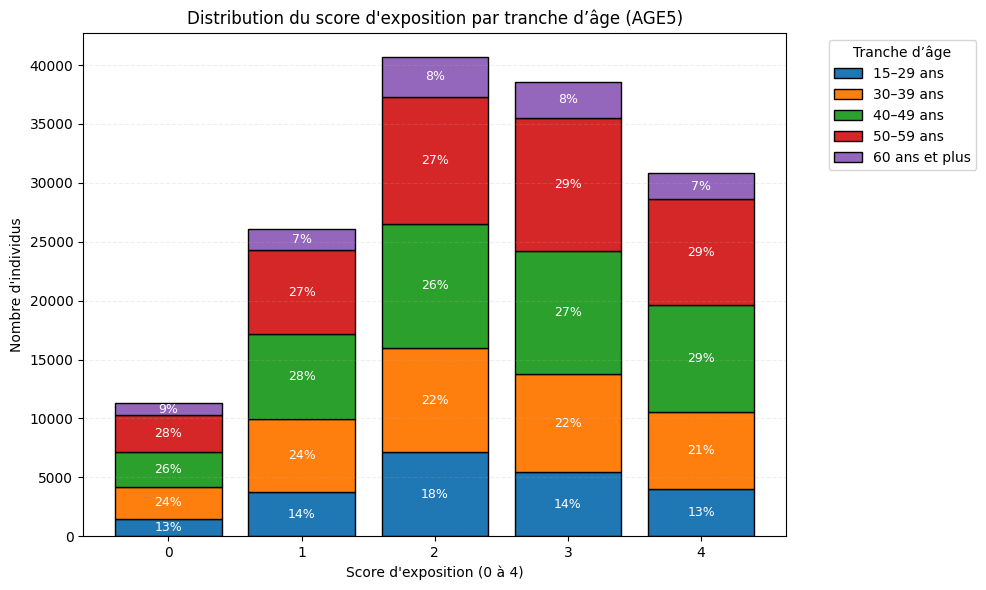

In [48]:
# Dictionnaire des libellés AGE5
age5_labels = {
    15: "15–29 ans",
    30: "30–39 ans",
    40: "40–49 ans",
    50: "50–59 ans",
    60: "60 ans et plus"
    # 0–14 absente des fichiers INDIV → non incluse
}

# 1️⃣ Crosstab score_exposition vs AGE5
df_age5_score = pd.crosstab(
    eec20_actifs['score_exposition'],
    eec20_actifs['AGE5']
)

# Garder uniquement les modalités voulues et les renommer
df_age5_score = df_age5_score[age5_labels.keys()]
df_age5_score.rename(columns=age5_labels, inplace=True)

# 2️⃣ Graphique à barres empilées
plt.figure(figsize=(10,6))

bottom = np.zeros(len(df_age5_score))

for age in df_age5_score.columns:
    plt.bar(
        df_age5_score.index,
        df_age5_score[age],
        bottom=bottom,
        label=age,
        edgecolor='black'
    )
    bottom += df_age5_score[age].values

# Ajouter les pourcentages au centre de chaque segment
for i, row in df_age5_score.iterrows():
    total = row.sum()
    cumul = 0
    for val in row:
        if val > 0:
            plt.text(
                i,
                cumul + val / 2,
                f"{val / total * 100:.0f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white'
            )
        cumul += val

plt.xticks(df_age5_score.index)
plt.xlabel("Score d'exposition (0 à 4)")
plt.ylabel("Nombre d'individus")
plt.title("Distribution du score d'exposition par tranche d’âge (AGE5)")
plt.legend(title="Tranche d’âge", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


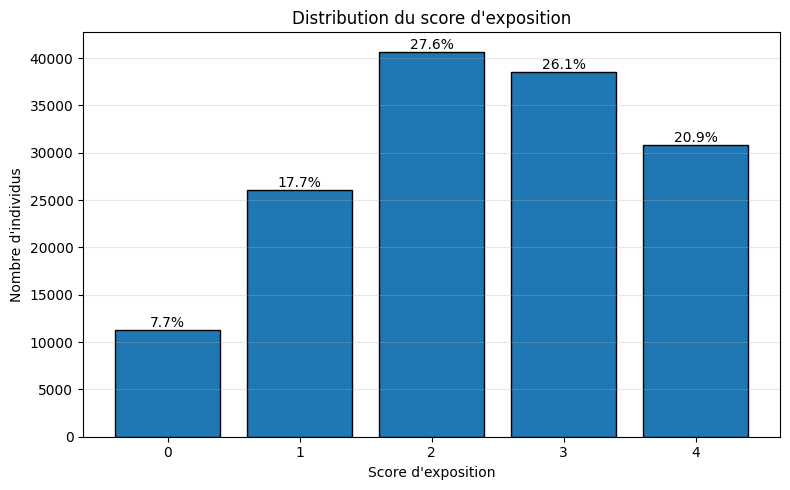

In [52]:
import_eec.plot_score_exposition(eec20_actifs)

In [54]:
import_eec.plot_score_exposition(eec20_actifs, by="SEXE", labels={1: "Homme", 2: "Femme"})


TypeError: plot_score_exposition() got an unexpected keyword argument 'labels'

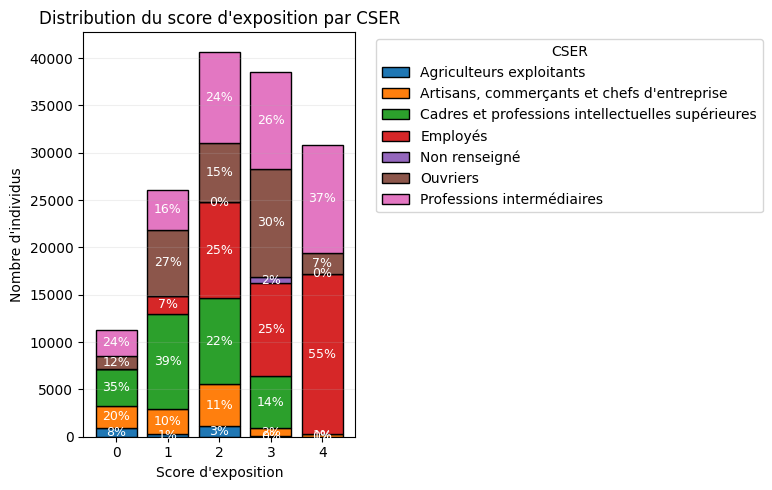

In [ ]:
import_eec.plot_score_exposition(eec20_actifs, by="CSER", labels = {
    0: "Non renseigné",
    1: "Agriculteurs exploitants",
    2: "Artisans, commerçants et chefs d'entreprise",
    3: "Cadres et professions intellectuelles supérieures",
    4: "Professions intermédiaires",
    5: "Employés",
    6: "Ouvriers",
 })


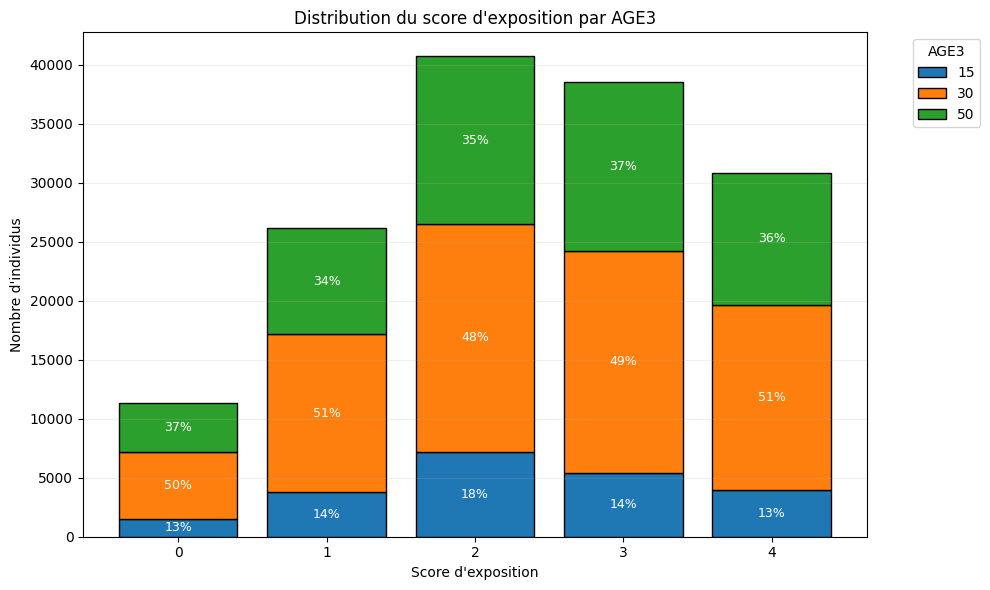

In [53]:
import_eec.plot_score_distribution(eec20_actifs, by="AGE3", figsize=(10,6))

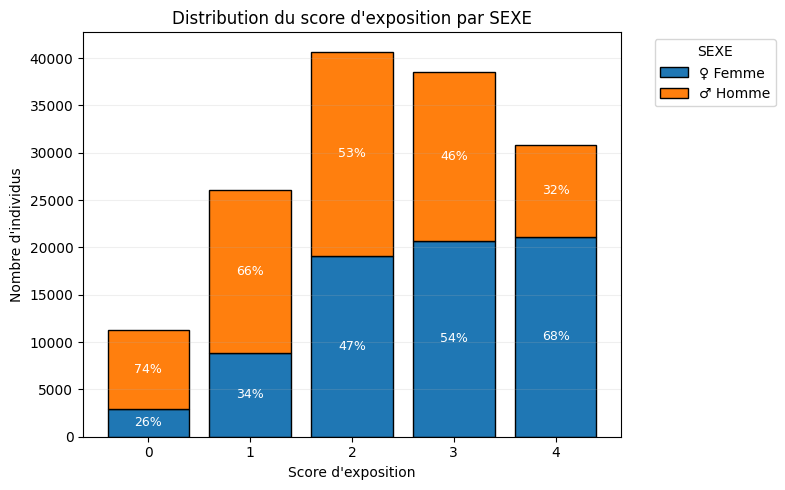

In [54]:
import_eec.plot_score_distribution(
    eec20_actifs,
    by="SEXE",
    labels={2: "♀ Femme",1: "♂ Homme"}
)

In [ ]:
## AFFICHER TOUTES LES COMBINAISONS ET LEUR SCORE D'EXPOSITION pour en vérifier la cohérence avec la littérature

# 1. Grouper par combinaison et score, compter les effectifs
df_combi_score = (
    eec20.groupby(['CSE_label', 'NAF_label', 'score_exposition'])
          .size()
          .reset_index(name='effectif')
)

# 2. Trier par score décroissant puis par effectif, puis CSE et NAF
df_combi_score_sorted = df_combi_score.sort_values(
    by=['score_exposition', 'effectif', 'CSE_label', 'NAF_label'],
    ascending=[False, False, True, True]
).reset_index(drop=True)

# 3. Afficher le tableau : code mis en commentaire: pour afficher les 900 lignes

#pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
#pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
#pd.set_option('display.width', 200)

df_combi_score_sorted.head()


,CSE_label,NAF_label,score_exposition,effectif
0,Professions santé & travail social,Activités pour la santé humaine,4,4536
1,Employés civils & agents de service FP,Administration publique,4,4029
2,Employés civils & agents de service FP,Activités pour la santé humaine,4,3052
3,Employés civils & agents de service FP,Hébergement médico-social & action sociale,4,2821
4,Employés civils & agents de service FP,Enseignement,4,2150
5,Intermédiaires admin. fonction publique,Administration publique,4,2149
6,Professions santé & travail social,Hébergement médico-social & action sociale,4,2038
7,Policiers & militaires,Administration publique,4,1557
8,Professions santé & travail social,Administration publique,4,710
9,Policiers & militaires,Services administratifs & soutien,4,658
